In [1]:
import openpmd_api as io

file = "/home/yujq2/users/caijie/Data/Betatron/diags_track/hdf5/data00000002.h5"
series = io.Series(file, io.Access_Type.read_only)
for iteration in series.iterations:
    i = series.iterations[iteration]
    dt = i.get_attribute("dt") * 2

In [2]:
import numpy as np
from fourier_radiator.utils import get_particle_data, track_particles

# 计算动能并筛选动能大于阈值的粒子ID
def get_selected_pid(ux, uy, uz, threshold_energy):
    # 计算粒子的速度
    u = np.sqrt(ux**2 + uy**2 + uz**2)
    
    # 筛选出动能大于阈值的粒子 ID
    selected_pid = u > threshold_energy
    return selected_pid

In [3]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.constants import m_e, c

# Function to check if file exists in the HDF5 format and read it
def load_from_hdf5(hdf5_path):
    if os.path.exists(hdf5_path):
        print(f"Loading data from {hdf5_path}")
        # Read the DataFrame from HDF5 file using pandas
        df = pd.read_hdf(hdf5_path, "df_tracks")  # Assuming 'df_tracks' is the key in the HDF5 file
        return df
    else:
        return None

# Function to save data to HDF5 using pandas
def save_to_hdf5(df, hdf5_path):
    # Save the DataFrame to HDF5
    df.to_hdf(hdf5_path, "df_tracks")
    print(f"Data saved to {hdf5_path}")

def get_track(wkdir, initial_file):
    filedir = Path(wkdir)
    # Get the particle data
    x, y, z, ux, uy, uz, w, pid = get_particle_data(str(filedir / initial_file))
    
    # Get selected particle IDs based on threshold energy
    selected_pid = get_selected_pid(ux, uy, uz, threshold_energy)
    selected_pid_values = pid[selected_pid]
    
    # Track particles (compute the particle trajectories)
    tracks_data = track_particles(wkdir, selected_pid_values)
    
    # Convert the tracks data into DataFrame
    df = pd.DataFrame(tracks_data).T
    
    # Apply map to convert lists to numpy arrays
    df = df.map(lambda x: np.array(x, dtype = np.float32) if isinstance(x, list) else x)
    
    return df

# Set file path
wkdir = "/home/yujq2/users/caijie/Data/Betatron/diags_track/hdf5"

# Set energy threshold
threshold_energy = 40 * m_e * c  # Energy threshold

# Set the file name
initial_file = "data00004000.h5"
hdf5_file_path = "./tracks_data.h5"

# Check if tracks data exists in HDF5 file
tracks_data = load_from_hdf5(hdf5_file_path)

# If data doesn't exist in HDF5, compute and store it
if tracks_data is None:
    df = get_track(wkdir, initial_file)
    # Save the computed data to HDF5
    save_to_hdf5(df, hdf5_file_path)
else:
    # If data exists, load it into a DataFrame
    df = pd.DataFrame(tracks_data)
    print(f"Data loaded from {hdf5_file_path}")
    
# Now you have the DataFrame `df` ready for further analysis or processing

Loading data from ./tracks_data.h5
Data loaded from ./tracks_data.h5


In [4]:
# df = df.map(lambda x: np.array(x, dtype = np.float32) if isinstance(x, np.ndarray) else x)

In [5]:
data = df.values

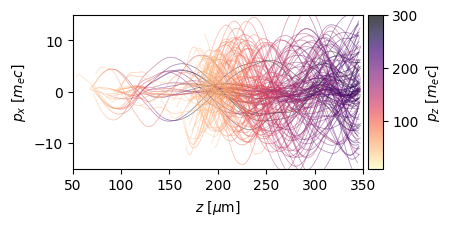

In [6]:
import matplotlib.pyplot as plt
from sliceplots import plot_multicolored_line, addcolorbar, Plot2D

fig, ax = plt.subplots(figsize=(4, 2))
for track in data[::10]:
    x, y, z, ux, uy, uz, w, id_start = track
    _, line = plot_multicolored_line(
        ax=ax,
        x=z*1e6,
        y=ux,
        other_y=uz,
        vmin=10,
        vmax=300,
        linewidth=0.4,
        alpha=0.7,
        cmap=plt.cm.magma_r,
    )
ax.set(
    ylabel="$p_x$ [$m_e c$]", xlabel="$z$ [$\mu$m]", xlim=(50, 350), ylim=(-15, 15)
)
cax = addcolorbar(ax=ax, mappable=line, label="$p_z$ [$m_e c$]")

In [ ]:
from fourier_radiator import FourierRadiator
from scipy.constants import hbar, alpha as alpha_fs

def norm_val(val):
    """
    Normalize the spectrum values.
    """
    lambda_u = 1.0
    J_in_um = 2 * np.pi * hbar * c * 1e6
    val = alpha_fs / (4 * np.pi**2) * val
    lambda0_um = lambda_u / 1e-6
    val *= J_in_um / lambda0_um
    return val

def norm_omega(omega):
    return omega * (2*np.pi*c)

calc_input = {
    "grid": [ (10 * 1e6, 1.2e4 * 1e6),
                (0, 0.03),
                (0.0, 2 * np.pi),
                (256, 36, 36)],
    "dtype": "double",
    # "native": False,
}

calc = FourierRadiator(calc_input)
calc.calculate_spectrum( particleTracks=data,
                         #comp='cartesian_complex',
                        #  file_spectrum = './spect_incoh.h5',
                         timeStep=c*dt )

theta = calc.Args['theta']
phi = calc.Args['phi']
omega = calc.Args['omega']
spectrum = calc.Data['radiation']['total']
spectrum = norm_val(spectrum)
omega = norm_omega(omega)

Using individual it_range per track


  1%|          | 13/1266 [00:00<00:34, 35.80it/s]

100%|██████████| 1266/1266 [00:25<00:00, 50.34it/s]


#### Error version

In [ ]:
# from fourier_radiator import FourierRadiator

# calc = FourierRadiator(dtype="float")

# # Assuming `calc` is an instance of the `FourierRadiator` class
# # Define the parameters

# nSnaps = 1

# # Given grid
# grid = [
#     (10 * 1e6, 1.2e4 * 1e6),  # omega range
#     (0, 0.03),  # theta range
#     (0.0, 2 * np.pi),  # phi range
#     (256, 36, 36)  # resolution (number of points in omega, theta, phi)
# ]

# # Generate the omega, theta, phi arrays
# omega = np.linspace(grid[0][0], grid[0][1], grid[3][0])  # omega range with 256 points
# theta = np.linspace(grid[1][0], grid[1][1], grid[3][1])  # theta range with 36 points
# phi = np.linspace(grid[2][0], grid[2][1], grid[3][2])  # phi range with 36 points

# # Call compute_radiation with kwargs
# spectrum = calc.compute_radiation(
#     tracks=data,          # Particle track data
#     omega=omega,            # Angular frequency
#     theta=theta,            # Theta angles
#     phi=phi,                # Phi angles
#     dt=dt,                  # Time step
#     nSnaps=nSnaps           # Number of snapshots
# )


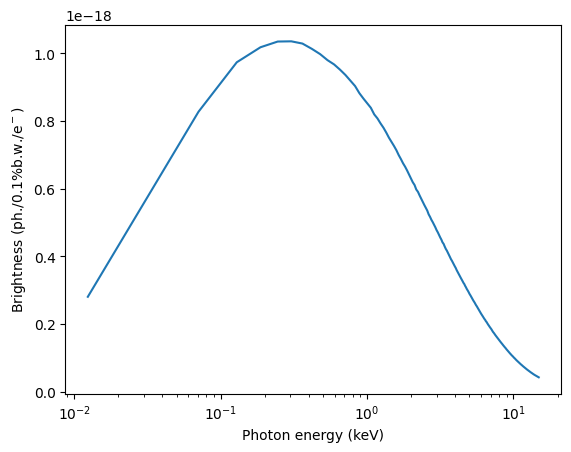

In [ ]:
import matplotlib.pyplot as plt
from scipy.constants import alpha as alpha_fs, hbar, e

def get_spectrum(omega, theta, phi, val):
    d_phi = phi[1] - phi[0]
    theta_loc = 0.5 * (theta[1:] + theta[:-1])
    val_loc = 0.5 * (val[:,1:,:] + val[:,:-1,:])
    int_theta = np.trapz( val_loc * np.sin(theta_loc)[None,:,None],
                                    theta_loc, axis=1)
    val = d_phi * int_theta.sum(-1)
    return val

val = spectrum[-1]

spectrum_1d = get_spectrum(omega, theta, phi, val)
# E_eV = hbar * omega / e       # 单位：eV
E_eV = omega * hbar / e
E_keV = E_eV / 1e3
plt.figure()
plt.plot(E_keV, spectrum_1d)
plt.xscale('log')
plt.xlabel("Photon energy (keV)")
plt.ylabel("Brightness (ph./0.1%b.w./e$^-$)")
plt.savefig("energy_spectrum_1D.png")

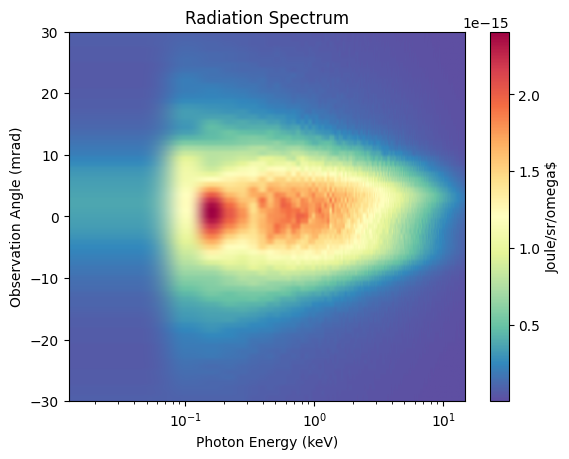

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import alpha as alpha_fs

def plot_spectrum_image(omega, theta, phi, val):
    """
    绘制二维谱图图像。

    参数:
    - spectrum: numpy 数组, 包含频谱数据，最后一个元素应为目标谱线数据。
    - calc: 一个对象，包含 `Args` 字典，包括 'theta', 'phi', 和 'omega'。
    - omega_ch_crit: 临界频率（用于归一化谱轴），默认为 None（跳过归一化轴）。
    - cmap: matplotlib colormap，用于图像色图绘制。

    返回:
    - None (直接显示图像)
    """
    
    omega_1m = 2 * np.pi * c # m/s

    # # 处理谱数据
    # spect_val = spectrum[-1].astype(np.double)
    # spect_val = alpha_fs / (4 * np.pi**2) * spect_val
    spect_val = val

    # 拼接上下半部分角度数据（对称轴合并）
    spect_val = np.c_[
        spect_val[:, :, spect_val.shape[2] // 2 - 1][:, ::-1],  # 左半部分反转
        spect_val[:, 1:, 0]                                     # 右半部分
    ]

    # 坐标轴计算
    spect_ax_keV = omega * hbar/e * 1e-3  # λ = 1.24 / E(eV) -> E(eV) = h·ω / e
    
    extent = [
        spect_ax_keV.min(), 
        spect_ax_keV.max(), 
        -theta.max() * 1e3, 
         theta.max() * 1e3
    ]
    return extent, spect_val

extent, spect_val = plot_spectrum_image(omega, theta, phi, val)

# 绘图
plt.figure()
plt.imshow(
    spect_val.T,
    extent=extent,
    cmap=plt.cm.Spectral_r,
    origin='lower',
    aspect='auto'
)
plt.xscale("log")
plt.xlabel("Photon Energy (keV)")
plt.ylabel("Observation Angle (mrad)")
plt.title("Radiation Spectrum")
plt.colorbar(label='Joule/sr/omega$')
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import griddata

def get_spot_cartesian_raw(omega, theta, phi, val, **kwargs):
    """
    从原始 spectrum[-1] 提取 theta-phi 分布，生成 2D 空间图。
    """
    th_part = kwargs.get('th_part', 1.0)  # theta 部分的比例
    k0 = kwargs.get('k0', None)  # 频率 k0，默认为 None
    bins = kwargs.get('bins', (100, 100))  # 网格分辨率
    
    # val = spectrum[-1].astype(np.double)  # shape: (omega, theta, phi)
    # val = norm_val(val)  # 归一化
    # 对 omega 维度积分或选取单频
    if k0 is None:
        val = np.trapz(val, omega, axis=0)  # shape: (theta, phi)
    else:
        idx = (omega < k0).sum()
        if idx + 1 < len(omega) and abs(omega[idx + 1] - k0) < abs(omega[idx] - k0):
            idx += 1
        val = val[idx]  # shape: (theta, phi)

    # 构建角度坐标
    ph_grid, th_grid = np.meshgrid(phi, theta)

    if val.shape != ph_grid.shape:
        val = val.reshape(ph_grid.shape)

    x = (th_grid * np.cos(ph_grid)).flatten()
    y = (th_grid * np.sin(ph_grid)).flatten()
    coord = (x, y)

    th_max = th_part * theta.max()
    grid_x, grid_y = np.mgrid[-th_max:th_max:bins[0]*1j, -th_max:th_max:bins[1]*1j]

    val_img = griddata(coord, val.flatten(), (grid_x, grid_y), method='linear', fill_value=0.)

    extent = [-th_max, th_max, -th_max, th_max]
    return val_img, extent

Text(0, 0.5, 'y-plane angle (mrad)')

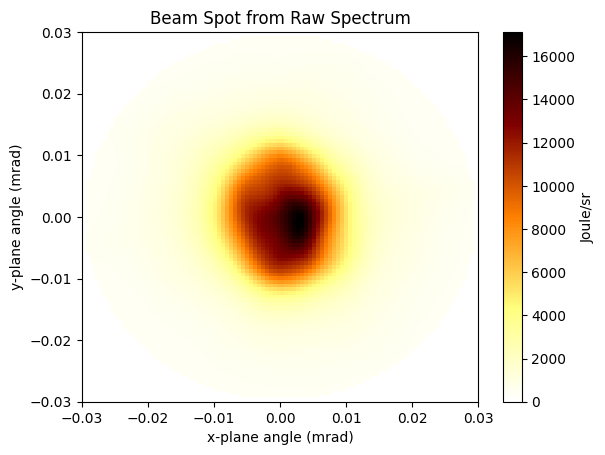

In [ ]:
val_img, extent = get_spot_cartesian_raw(omega, theta, phi, val)

plt.figure()
plt.imshow(val_img.T, extent=extent, origin='lower', aspect='auto', cmap='afmhot_r')
plt.xlabel("X (rad)")
plt.ylabel("Y (rad)")
plt.title("Beam Spot from Raw Spectrum")
plt.colorbar(label="Joule/sr")
# plt.show()
plt.xlabel("x-plane angle (mrad)")
plt.ylabel("y-plane angle (mrad)")